<h1>On the Importance of Hyperparameter Selection when Choosing Control Variables with LASSO (Institutions)<h1>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  5 11:23:43 2021

@author: berkay akyapi
"""

import sys
import os

import numpy as np
import pandas as pd
import sklearn
import numpy.matlib

from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import norm # Needed for the calculation of penalties


# Check software versions
print('### Python version: ' + __import__('sys').version) # 3.8.5
print('### NumPy version: ' + np.__version__) # 1.19.2
print('### Scikit-learn version: ' + sklearn.__version__) # 0.23.2
print('------------')


### Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.19.2
### Scikit-learn version: 0.23.2
------------


<h2>Define Functions<h2>

<h3>The following function aims to calculate robust standard errors. The errors calculated seem to be smaller than the ones calculated in Stata. As error terms does not change the main exercise results (that we cannot choose a priori the best hyperparameters) I left it as it is. <h3>

In [30]:
def robustErrors(controls, dependent, yhat):
    
    
    n = controls.shape[0]
    dim = controls.shape[1]
    c = (n-1)/(n-dim)
    e = dependent - yhat
    e = e.reshape(-1,1)
    V = e*controls
    PhiHat = c*V.T@V
    XTXinv = np.linalg.inv(controls.T@controls)
    
    vrobust = XTXinv@PhiHat@XTXinv

    se = np.sqrt(np.diag(vrobust))
    return se

<h2>The following two functions are the main functions for Lasso. I could not use existing packages, because of the way the weight matrix is calculated. Therefore, I needed to create my own Lasso Shooting function. I took advantage of the replication files of 'Belloni, Cherhoznukov, and Hansen 2014'. Their files were in Matlab. I implemented their codes using Python.<h2>

In [3]:
def LassoShooting(X, y, myLam, loadings, myModel, maxiter = 10000, optTol = 1e-5):
    # This function is derived from the replication files of Belloni, Cherhoznukov,
    # and Hansen 2014 "Inference on Treatment Effects after Selection among High-Dimensional Controls"
    # The replication files included Matlab codes.
    
    p = X.shape[1]
    
    XX = np.transpose(X)@X
    Xy = np.transpose(X)@y
    
    
    #myBeta = myModel.fit(X, y).coef_
    myBeta = np.linalg.inv(XX + myLam*np.diag(np.ones(p)))@Xy
    m = 0
    
    XX2 = XX*2
    Xy2 = Xy*2
    
    while m < maxiter:
        beta_old = myBeta.copy()
        
        for j in range(p):
            S0 = np.sum(XX2[j,:]@myBeta) - XX2[j,j]*myBeta[j] - Xy2[j]
            thresh = myLam*loadings[j]
            if S0 > thresh:
                #print('Previous beta is {: .5f}'.format(myBeta[j,]))
                myBeta[j] = (thresh - S0)/XX2[j,j]
                #print('New beta is {: .5f}'.format(myBeta[j,]))
            elif S0 < -thresh:
                #print('Previous beta is {: .5f}'.format(myBeta[j,]))
                myBeta[j] = (-thresh - S0)/XX2[j,j]
                #print('New beta is {: .5f}'.format(myBeta[j,]))
            elif np.abs(S0)<=thresh:
                myBeta[j] = 0

                
        m = m + 1 
        #print('Iteration in Lasso Shooting {}'.format(m))
        
        if np.sum(np.abs(myBeta-beta_old))<optTol:
            break
    if m >= maxiter:
        print('No convergence in coefficient calculation')
        
    return myBeta

def chooseVariables(X,y, myLam, verbose = 0, maxIter = 100, useSeed = True):
    reg_temp = LinearRegression().fit(X, y)

    errors = y-reg_temp.predict(X)
    loading0 = X*np.repeat(errors.reshape((-1,1)),X.shape[1],1)
    loading0 = np.sqrt(np.sum(np.square(loading0),axis=0))/np.sqrt(X.shape[0])
    
    if useSeed:
        myModel = linear_model.Ridge(alpha=myLam, random_state = 42) 
        # Initial beta will be calculated through Ridge regression.
    else:
        myModel = linear_model.Ridge(alpha=myLam)
        
    initialBeta = LassoShooting(X, y, myLam, loading0, myModel)
    
   
    theResiduals = y - X@initialBeta
    
    kk = 1
    loading1 = X*np.repeat(theResiduals.reshape((-1,1)), X.shape[1],1)
    loading1 = np.sqrt(np.sum(np.square(loading1),axis=0))/np.sqrt(X.shape[0])
    
    while np.linalg.norm(loading1-loading0) > 1e-4 and kk < maxIter:
        
        myBeta = LassoShooting(X, y, myLam, loading1, myModel)
    
        Indbeta = np.where(myBeta != 0)[0]

        loading0 = loading1
        loading1 = X*np.repeat((y-X@myBeta).reshape((-1,1)) ,X.shape[1],1)
        loading1 = np.sqrt(np.sum(np.square(loading1),axis=0))/np.sqrt(X.shape[0])
        if verbose == 1:
            print('Iteration {: }, shape of beta is {: }'.format(kk, Indbeta.shape[0]))
        kk = kk + 1
    if kk >= maxIter:
        print('No convergence in Loadings')
    if verbose == 1:
        print('')
    myBeta = myBeta.reshape(-1,1)
    loading1 = loading1.reshape(-1,1)
    loss = np.sum(np.square(y-X@myBeta)) \
        + myLam*np.sum(np.abs(myBeta).T @ loading1)
    #loss = r2_score(y, X@myBeta, multioutput='variance_weighted')

    return Indbeta, loss

Read the data and use built-in IV regression. The coefficient values are the same as the ones in STATA, however standard errors differ slightly. The inconsistency between both programming languages is out of scope of this exercise and is left as a future work.

In [4]:
# Read data
theData = pd.read_stata('acemoglu_col_notext.dta')

# Summarize some information
theData.info()

# Show how the data looks like
theData.head()

# First check is we can get the same results with linearmodels
from linearmodels import IV2SLS

theData['lnmort'] = np.log(theData['mort'])
theData['const'] = 1

ivmod = IV2SLS(theData['gdp'], theData[['latitude', 'const']], theData['exprop'], theData['lnmort'])
res_2sls = ivmod.fit(cov_type='robust')
print(res_2sls.summary)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gdp       64 non-null     float32
 1   exprop    64 non-null     float32
 2   mort      64 non-null     float32
 3   latitude  64 non-null     float32
 4   neo       64 non-null     int8   
 5   africa    64 non-null     int8   
 6   asia      64 non-null     int8   
 7   namer     64 non-null     int8   
 8   samer     64 non-null     int8   
dtypes: float32(4), int8(5)
memory usage: 1.8 KB
                          IV-2SLS Estimation Summary                          
Dep. Variable:                    gdp   R-squared:                      0.1523
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1245
No. Observations:                  64   F-statistic:                    28.979
Date:                Tue, Apr 06 2021   P-value (F-stat)                0.0000
Time:                    

<h5>Create additional control variables and convert to numpy<h5>

In [5]:
# Create additional control variables
theData['lat2'] = np.square(theData['latitude'])
theData['lat3'] = np.square(theData['latitude'])*theData['latitude'].to_numpy()
theData['lat_c08'] = np.abs((theData['latitude'].to_numpy()-.08)*(theData['latitude'].to_numpy()>.08))
theData['lat2_c08'] = np.square(theData['lat_c08'])
theData['lat3_c08'] = np.square(theData['lat_c08'])*theData['lat_c08'].to_numpy()

theData['lat_c16'] = np.abs((theData['latitude'].to_numpy()-.16)*(theData['latitude'].to_numpy()>.16))
theData['lat2_c16'] = np.square(theData['lat_c16'])
theData['lat3_c16'] = np.square(theData['lat_c16'])*theData['lat_c16'].to_numpy()

theData['lat_c24'] = np.abs((theData['latitude'].to_numpy()-.24)*(theData['latitude'].to_numpy()>.24))
theData['lat2_c24'] = np.square(theData['lat_c24'])
theData['lat3_c24'] = np.square(theData['lat_c24'])*theData['lat_c24'].to_numpy()

# Get all control variables, with the same order as original paper
controls = ['africa', 'asia','namer', 'samer','latitude','lat2','lat3', 'lat_c08',
            'lat2_c08','lat3_c08','lat_c16', 'lat2_c16','lat3_c16', 'lat_c24',
            'lat2_c24','lat3_c24']

# Convert to numpy
allControls = theData[controls].to_numpy()
gdp = theData['gdp'].to_numpy() # This is the dependent variable
exprop = theData['exprop'].to_numpy() # This is the endogenous independent variable
lnmort = theData['lnmort'].to_numpy() #

<h5>Run 2SLS using sklearn package with all potential controls.<h5>

The coefficients are the same as in STATA, however error terms differ. I could not find how STATA calculates robust standard errors and why this difference in standard errors are occuring. In addition, standard errors do not change the results. In other words, when I run the regressions with the chosen variables (in Python) through Lasso in STATA, I again obtain the same coefficient values and they are still significant. Therefore, standard erros can be ignored in the rest of the exercise.

In [32]:
firstStageCont = np.concatenate((lnmort.reshape(-1,1), allControls), axis = 1)

reg = LinearRegression().fit(firstStageCont, exprop)
print('')
print('First stage coefficient is: {: .3f}'.format(reg.coef_[0]))
se = robustErrors(firstStageCont, exprop, reg.predict(firstStageCont))
print('Standard error is: {: .3f}'.format(se[0]))


pexprop = reg.predict(firstStageCont).reshape(-1,1)

secondStageCont = np.concatenate((pexprop, allControls), axis = 1)

reg = LinearRegression().fit(secondStageCont, gdp)
print('Second stage coefficient (the coefficient of interest) is: {: .3f}'.format(reg.coef_[0]))
se = robustErrors(secondStageCont, gdp,reg.predict(secondStageCont))
print('Standard error is: {: .3f}'.format(se[0]))


First stage coefficient is: -0.218
Standard error is:  0.191
Second stage coefficient (the coefficient of interest) is:  0.989
Standard error is:  0.106


<h3>Beginning LASSO Exercise<h3>

In [33]:
n = allControls.shape[0]
p = allControls.shape[1]

import random
random.seed(42)
cs = np.asarray([1 + (random.random() * (1.25 - 1)),
                 1 + (random.random() * (1.25 - 1)), 
                 1 + (random.random() * (1.25 - 1))])
cs.sort()
cs = np.concatenate(([1.1], cs)) # Make suggested c=1.1 the first element

gams = np.asarray([.05, .1/np.log(n)]) #Two suggested gammas

m = 0

controls = numpy.asarray(controls)

for c, g in [(c,g) for c in cs for g in gams]:

    myLam = 2*c*np.sqrt(n)*norm.ppf(1-g/(2*p))
    
    gdpBeta, lossgdp = chooseVariables(allControls,gdp, myLam)
    
    propBeta, lossProp = chooseVariables(allControls,exprop, myLam)
    
    mortBeta, lossMort = chooseVariables(allControls,lnmort, myLam)
    
    union_controls = np.union1d(gdpBeta,propBeta)
    union_controls = np.union1d(union_controls,mortBeta)
    
    chosenControls = allControls[:,union_controls]
    
    print('CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES')

    print('')
    print('The chosen variables are ', controls[union_controls])
    print('')
        
    firstStageCont = np.concatenate((lnmort.reshape(-1,1), chosenControls), axis = 1)

    reg1 = LinearRegression().fit(firstStageCont, exprop)
    print('')
    print('First stage coefficient is: {: .4f}'.format(reg1.coef_[0]))
    se1 = robustErrors(firstStageCont, exprop, reg1.predict(firstStageCont))
    print('Standard error is: {: .3f}'.format(se1[0]))
    pexprop = reg1.predict(firstStageCont).reshape(-1,1)
    
    secondStageCont = np.concatenate((pexprop, chosenControls), axis = 1)
    
    reg = LinearRegression().fit(secondStageCont, gdp)
    print('Second stage coefficient is {: .4f}'.format(reg.coef_[0]))
    se = robustErrors(secondStageCont, gdp,reg.predict(secondStageCont))
    print('Standard error is: {: .3f}'.format(se[0]))
    print('---------------------------------------------------------------------')

    r2Inst = r2_score(gdp, reg.predict(secondStageCont), multioutput='variance_weighted')

    if m == 0:
        InstChoices = {str(m): {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': controls[union_controls],
           'No. of Chosen Controls': controls[union_controls].shape[0],
           'Coef 1st Stage': reg1.coef_[0],
           'se 1st Stage': se1[0], 
           'Coef 2nd Stage': reg.coef_[0],
           'se 2nd Stage': se[0],'r2Score': r2Inst}
           }
    else:
        InstChoices[str(m)] = {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': controls[union_controls],
           'No. of Chosen Controls': controls[union_controls].shape[0],
           'Coef 1st Stage': reg1.coef_[0],
           'se 1st Stage': se1[0], 
           'Coef 2nd Stage': reg.coef_[0],
           'se 2nd Stage': se[0],'r2Score': r2Inst}
        
    m = m+1

CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES

The chosen variables are  ['africa' 'namer' 'latitude']


First stage coefficient is: -0.4108
Standard error is:  0.065
Second stage coefficient is  0.8964
Standard error is:  0.030
---------------------------------------------------------------------
CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES

The chosen variables are  ['africa' 'latitude']


First stage coefficient is: -0.4497
Standard error is:  0.056
Second stage coefficient is  0.7937
Standard error is:  0.026
---------------------------------------------------------------------
CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES

The chosen variables are  ['africa' 'namer' 'samer' 'latitude']


First stage coefficient is: -0.3773
Standard error is:  0.095
Second stage coefficient is  1.0501
Standard error is:  0.044
---------------------------------------------------------------------
CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES

The chosen variables

The next cells plots and reports the c and gamma choices that maximize R-Squared in the regressions.

In [34]:
ylineInst = np.zeros((m, 1))

xlineInst = np.zeros((m, 1))



for i in range(0,m):
    ylineInst[i] = InstChoices[str(i)]['r2Score']
    xlineInst[i] = InstChoices[str(i)]['penalty']
    
    if i == 0:
        xmaxInst = xlineInst[i]
        maxInst = ylineInst[i]
        cInst = InstChoices[str(i)]['c']
        gInst = InstChoices[str(i)]['gamma']
        coefInst = InstChoices[str(i)]['Coef 2nd Stage']
        seInst = InstChoices[str(i)]['se 2nd Stage']
    elif ylineInst[i] > maxInst: # If equal still pick 1.1
        xmaxInst = xlineInst[i]    
        maxInst = ylineInst[i]
        cInst = InstChoices[str(i)]['c']
        gInst = InstChoices[str(i)]['gamma']
        coefInst = InstChoices[str(i)]['Coef 2nd Stage']
        seInst = InstChoices[str(i)]['se 2nd Stage']

In [35]:
print('---------------------------------------------------------------------')
print('')
print('Maximum r2 is reached when c={: .3f} and gamma={: .2f}'.format(cInst, gInst))
print('')
print('Coefficient of 2nd Stage Regression is: {: .3f}'.format(coefInst))
print('(Robust) Standard error is: {: .3f}'.format(seInst))
print('')
print('---------------------------------------------------------------------')


---------------------------------------------------------------------

Maximum r2 is reached when c= 1.006 and gamma= 0.05

Coefficient of 2nd Stage Regression is:  1.050
(Robust) Standard error is:  0.044

---------------------------------------------------------------------


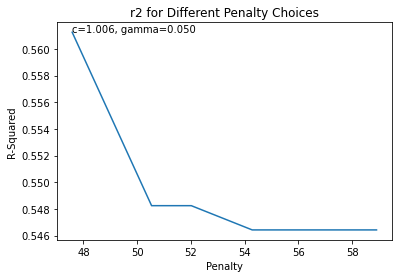

In [36]:
xlineInst, ylineInst = zip(*sorted(zip(xlineInst, ylineInst)))

plt.plot(xlineInst, ylineInst)
plt.title('r2 for Different Penalty Choices')
plt.xlabel('Penalty')
plt.ylabel('R-Squared')
myText= 'c={:.3f}, gamma={:.3f}'.format(cInst, gInst)
plt.text(xmaxInst, maxInst, myText)
plt.show()
